# 👨‍🚒 Практический урок по бустингам

<center>

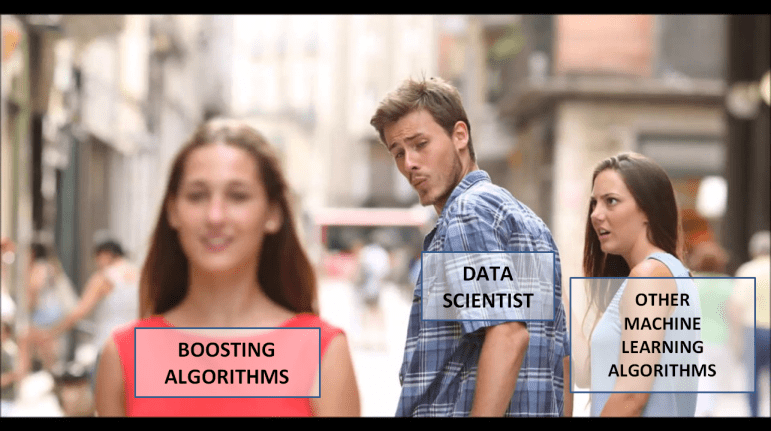
</center>

# Libraries

In [21]:
# Random Seed
random_seed = 77611009

# Data
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

# Machine Learning
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor, DMatrix
from lightgbm import LGBMRegressor, Dataset
import lightgbm as lgb

# Data Prepare

In [22]:
train_url = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv'
test_url = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv'

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)
test_car_id = test['car_id']

In [23]:
def drop_trash_columns(df: pd.DataFrame, inplace=False):
    """
    Return dataframe without trash columns like id, etc.
    """
    trash_columns = ['car_id', 'target_class'] # We dont need target_class because we dont guess it
    if set(trash_columns).issubset(df.columns):
        return df.drop(columns=trash_columns, inplace=inplace)
    return df

In [24]:
drop_trash_columns(train, inplace=True)
drop_trash_columns(test, inplace=True)

In [25]:
train

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,4.737759,1.214131e+07,0.10,180.855726,0.023174,174,170
1,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,4.480517,1.803909e+07,0.00,187.862734,12.306011,174,174
2,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,4.768391,1.588366e+07,0.10,102.382857,2.513319,174,173
3,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,3.880920,1.651883e+07,0.10,172.793237,-5.029476,174,170
4,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,4.181149,1.398317e+07,0.10,203.462289,-14.260456,174,171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,Smart ForFour,economy,petrol,4.38,2017,121239,2018,24.62,4.608908,1.739222e+07,0.10,141.502350,-6.624534,174,171
2333,Audi A4,premium,petrol,4.30,2016,107793,2020,70.58,4.683793,1.174052e+07,0.10,155.000000,-8.582467,174,169
2334,Kia Rio,economy,petrol,3.88,2015,80234,2019,45.50,4.655345,1.202022e+07,0.10,104.180940,-0.778524,174,172
2335,Renault Sandero,standart,petrol,4.50,2014,60048,2020,75.48,4.638333,1.788307e+07,0.10,200.000000,2.464975,174,171


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   model                     2337 non-null   object 
 1   car_type                  2337 non-null   object 
 2   fuel_type                 2337 non-null   object 
 3   car_rating                2337 non-null   float64
 4   year_to_start             2337 non-null   int64  
 5   riders                    2337 non-null   int64  
 6   year_to_work              2337 non-null   int64  
 7   target_reg                2337 non-null   float64
 8   mean_rating               2337 non-null   float64
 9   distance_sum              2337 non-null   float64
 10  rating_min                2337 non-null   float64
 11  speed_max                 2337 non-null   float64
 12  user_ride_quality_median  2337 non-null   float64
 13  deviation_normal_count    2337 non-null   int64  
 14  user_uni

In [27]:
train.describe()

,car_rating,year_to_start,riders,year_to_work,target_reg,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2.337000e+03,2337.000000,2337.000000,2337.000000,2337.0,2337.000000
mean,4.354292,2014.040650,63711.443731,2018.069748,44.947381,4.478831,1.356912e+07,0.138870,160.984884,-0.329339,174.0,171.624305
std,0.996954,1.685852,33755.012096,2.159484,17.647533,0.418588,4.253209e+06,0.163978,33.211161,9.581800,0.0,3.158088
min,0.980000,2011.000000,23.000000,2014.000000,17.640000,3.529885,1.478866e+06,0.000000,91.423508,-38.116345,174.0,136.000000
25%,3.740000,2013.000000,41053.000000,2016.000000,31.570000,4.155747,1.058758e+07,0.100000,123.609208,-6.141569,174.0,171.000000
50%,4.360000,2014.000000,64415.000000,2018.000000,40.010000,4.442989,1.321852e+07,0.100000,172.435742,-0.195860,174.0,172.000000
75%,5.000000,2015.000000,86515.000000,2020.000000,54.720000,4.675345,1.631788e+07,0.100000,188.597411,5.370422,174.0,173.000000
max,8.900000,2017.000000,142862.000000,2022.000000,141.130000,5.700747,3.119785e+07,1.500000,209.982840,35.770493,174.0,174.000000


In [28]:
def check_nans(df: pd.DataFrame):
    return df.isna().sum()

In [29]:
check_nans(train)

model                       0
car_type                    0
fuel_type                   0
car_rating                  0
year_to_start               0
riders                      0
year_to_work                0
target_reg                  0
mean_rating                 0
distance_sum                0
rating_min                  0
speed_max                   0
user_ride_quality_median    0
deviation_normal_count      0
user_uniq                   0
dtype: int64

In [30]:
check_nans(test)

model                       0
car_type                    0
fuel_type                   0
car_rating                  0
year_to_start               0
riders                      0
year_to_work                0
mean_rating                 0
distance_sum                0
rating_min                  0
speed_max                   0
user_ride_quality_median    0
deviation_normal_count      0
user_uniq                   0
dtype: int64

In [31]:
cat_features_alp = ['model', 'car_type', 'fuel_type', 
                'year_to_start', 'year_to_work']
cat_features_num = [0, 1, 2, 4, 6]
# Создадим два списка, потому что Catboost умеет принимать строковый тип колонок, а LightGBM - нет
X = train.drop(columns=['target_reg'])
y = train['target_reg']

## Folds

Сгенерируем отдельно фолды, а далее создадим для каждой из библиотек их способы хранение(Pool, DMatrix, Dataset)

In [32]:
n_splits = 3
kf = KFold(n_splits=n_splits)
train_folds = []
test_folds = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    train_folds.append((X_train, y_train))
    test_folds.append((X_test, y_test))

In [33]:
train_folds

[(                model  car_type fuel_type  car_rating  year_to_start  riders  \
  779    Renault Kaptur  standart    petrol        3.02           2015   87521   
  780    Renault Kaptur  standart    petrol        2.32           2014   69743   
  781       Smart Coupe   economy    petrol        2.68           2014   59036   
  782           VW Polo   economy    petrol        5.32           2013   39171   
  783         VW Tiguan   economy    petrol        2.36           2015   76737   
  ...               ...       ...       ...         ...            ...     ...   
  2332    Smart ForFour   economy    petrol        4.38           2017  121239   
  2333          Audi A4   premium    petrol        4.30           2016  107793   
  2334          Kia Rio   economy    petrol        3.88           2015   80234   
  2335  Renault Sandero  standart    petrol        4.50           2014   60048   
  2336          VW Polo   economy    petrol        3.94           2015   92312   
  
        year_

# Machine Learning

## Catboost

In [34]:
def generate_pools(list_folds: list):
    """ Return list of Pool for Catboost """
    list_pools = []
    for X, y in list_folds:
        list_pools.append(Pool(X, y, cat_features=cat_features_alp))
    return list_pools

In [35]:
catboost_train_pools = generate_pools(train_folds)
catboost_eval_pools = generate_pools(test_folds)

/nix/store/mpfzjnzb75x243yr3azmw9qr8kk2i66w-python3.10-catboost-1.0.5/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


In [36]:
catboost_clfs = []
catboost_scores = []

for index in range(n_splits):
    train_pool = catboost_train_pools[index]
    eval_pool = catboost_eval_pools[index]
    
    clf = CatBoostRegressor(
        depth=4,
        iterations=3500,
        learning_rate=0.06,
        custom_metric=["RMSE"],
        
        # Главная фишка катбуста - работа с категориальными признаками
        cat_features=cat_features_alp,
        # ignored_features = ignored_features,
        
        # Регуляризация и ускорение
        colsample_bylevel=0.098,
        subsample=0.95,
        l2_leaf_reg=9,
        min_data_in_leaf=243,
        max_bin=187,
        random_strength=1,
        
        # Параметры скорения
        task_type="CPU",    
        thread_count=-1,
        bootstrap_type="Bernoulli", 
        
        # Важное!
        random_seed=random_seed,
        early_stopping_rounds=700)

    clf.fit(
        train_pool,
        eval_set=eval_pool,
        verbose=500,
        use_best_model=True,
        plot=False)

    catboost_clfs.append(clf)
    
    catboost_scores.append(np.mean([v for k, v in clf.best_score_["validation"].items() if "RMSE" in k], dtype="float16"))
assert len(catboost_clfs) == n_splits
print("mean RMSE score --------->", np.mean(catboost_scores, dtype="float16") - np.std(catboost_scores, dtype="float16"))

0:	learn: 17.5712241	test: 17.7892673	best: 17.7892673 (0)	total: 413us	remaining: 1.45s
500:	learn: 10.4044317	test: 12.2484356	best: 12.2453667 (469)	total: 563ms	remaining: 3.37s
1000:	learn: 9.6836879	test: 12.2366200	best: 12.2207695 (675)	total: 901ms	remaining: 2.25s
Stopped by overfitting detector  (700 iterations wait)

bestTest = 12.22076945
bestIteration = 675

Shrink model to first 676 iterations.
0:	learn: 17.6879455	test: 17.5591625	best: 17.5591625 (0)	total: 3.52ms	remaining: 12.3s
500:	learn: 10.4873999	test: 11.7391667	best: 11.7382249 (498)	total: 366ms	remaining: 2.19s
1000:	learn: 9.7070481	test: 11.7495457	best: 11.7143038 (704)	total: 720ms	remaining: 1.8s
Stopped by overfitting detector  (700 iterations wait)

bestTest = 11.71430379
bestIteration = 704

Shrink model to first 705 iterations.
0:	learn: 17.6698134	test: 17.5922774	best: 17.5922774 (0)	total: 350us	remaining: 1.23s
500:	learn: 10.9095244	test: 11.2894687	best: 11.2841999 (448)	total: 353ms	remaining

In [37]:
catboost_best_model = catboost_clfs[np.array(catboost_scores).argmin()] # Лучший третий фолд
catboost_best_model.save_model('../../tmp_data/catboost.cbm')

# Predict

In [38]:
test

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,Skoda Rapid,economy,petrol,4.80,2013,42269,2019,3.746207,1.407539e+07,0.10,195.454152,10.566220,174,170
1,Renault Sandero,standart,petrol,4.32,2015,90014,2016,4.318966,1.970390e+07,0.00,181.538685,11.807941,174,174
2,Smart ForTwo,economy,petrol,4.46,2015,82684,2017,5.134655,9.314946e+06,0.10,118.440645,14.862538,174,172
3,Smart ForFour,economy,petrol,2.80,2014,68833,2021,4.617356,9.336838e+06,0.83,112.829785,20.088904,174,172
4,Skoda Rapid,economy,petrol,6.56,2013,42442,2021,4.287471,1.196250e+07,0.00,187.846088,3.698460,174,172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,Nissan Qashqai,standart,petrol,2.44,2015,81070,2016,4.641379,8.035217e+06,0.10,161.000000,5.426149,174,171
1909,Renault Kaptur,standart,petrol,4.44,2014,70067,2019,3.956954,1.792881e+07,0.10,195.394955,-6.225923,174,172
1910,Hyundai Solaris,economy,petrol,5.16,2011,6574,2022,4.607816,1.401163e+07,0.22,113.091551,-4.110241,174,172
1911,Hyundai Solaris,economy,petrol,5.76,2015,85648,2018,4.462644,1.375324e+07,0.10,154.105593,-4.337686,174,172


In [39]:
test['target_reg'] = catboost_best_model.predict(test)
test['car_id'] = test_car_id

/nix/store/mpfzjnzb75x243yr3azmw9qr8kk2i66w-python3.10-catboost-1.0.5/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


In [40]:
test[['car_id', 'target_reg']].to_csv('../../tmp_data/submit.csv', index=False)